**<center><font size=5>Brain Tumor Detection with VGG-16 Model</font></center>**
***
**author**: Ruslan Klymentiev

**date**: 10th June, 2019

**Table of Contents**
- <a href='#intro'>1. Project Overview and Objectives</a> 
    - <a href='#dataset'>1.1. Data Set Description</a>
    - <a href='#tumor'>1.2. What is Brain Tumor?</a>
- <a href='#env'>2. Setting up the Environment</a>
- <a href='#import'>3. Data Import and Preprocessing</a>
- <a href='#cnn'>4. CNN Model</a>
    - <a href='#aug'>4.1. Data Augmentation</a>
        - <a href='#demo'>4.1.1. Demo</a>
        - <a href='#apply'>4.1.2. Apply</a>

# <a id='intro'>1. Project Overview and Objectives</a>

The main purpose of this project was to build a CNN model that would classify if subject has a tumor or not base on MRI scan. I used the [VGG-16](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection) model architecture and weights to train the model for this binary problem. I used `accuracy` as a metric to justify the model performance which can be defined as:

$\textrm{Accuracy} = \frac{\textrm{Number of correclty predicted images}}{\textrm{Total number of tested images}} \times 100\%$

Final results look as follows:

| Set | Accuracy |
|:-:|:-:|
| Validation Set* | ~88% |
| Test Set* | ~80% |
<br>
\* *Note: there might be some misunderstanding in terms of set names so I want to describe what do I mean by `test` and `validation` set:*
* *`validation set` - is the set used during the model training to adjust the hyperparameters. *
* *`test set` - is the small set that I don't touch for the whole training process at all. It's been used for final model performance evaluation.*

## <a id='dataset'>1.1. Data Set Description</a>

The image data that was used for this problem is [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). It conists of MRI scans of two classes:

* `NO` - no tumor, encoded as `0`
* `YES` - tumor, encoded as `1`

Unfortunately, the data set description doesn't hold any information where this MRI scans come from and so on.

## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>
> *Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.*

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)

# <a id='env'>2. Setting up the Environment</a>

In [156]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [157]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 42

Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [158]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

The syntax of the command is incorrect.


Folder PATH listing for volume OS
Volume serial number is 00000096 F820:0148
C:\USERS\DAHAB\ONEDRIVE\DESKTOP\BRAIN TUMOR DETECTION\-D
Invalid path - \USERS\DAHAB\ONEDRIVE\DESKTOP\BRAIN TUMOR DETECTION\-D
No subfolders exist 



In [159]:
IMG_PATH = 'C:/Users/dahab/OneDrive/Desktop/Brain Tumor Detection/brain_tumor_dataset'

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):  # Skip system files like .DS_Store
        class_path = os.path.join(IMG_PATH, CLASS)
        FILES = os.listdir(class_path)
        IMG_NUM = len(FILES)

        for n, FILE_NAME in enumerate(FILES):
            img = os.path.join(class_path, FILE_NAME)

            # 80% for training, 10% for testing, 10% for validation
            if n < 0.8 * IMG_NUM:
                split = 'TRAIN'
            elif n < 0.9 * IMG_NUM:
                split = 'TEST'
            else:
                split = 'VAL'

            # Create destination folder if it doesn't exist
            dest_folder = os.path.join(split, CLASS.upper())
            os.makedirs(dest_folder, exist_ok=True)

            # Copy image to its destination
            shutil.copy(img, os.path.join(dest_folder, FILE_NAME))

# <a id='import'>3. Data Import and Preprocessing</a>

In [160]:
def load_data(dir_path, img_size):
    X = []
    y = []
    labels = []
    i = 0

    for folder in os.listdir(dir_path):
        if folder.startswith('.'):
            continue
        labels.append(folder)
        folder_path = os.path.join(dir_path, folder)

        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)

            # Read the image
            img = cv2.imread(file_path)
            if img is None:
                print(f'⚠️ Could not read image: {file_path}')
                continue

            # Resize the image
            img = cv2.resize(img, img_size)

            # Convert to RGB (if needed)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            X.append(img)
            y.append(i)

        i += 1

    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [161]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

203 images loaded from TRAIN/ directory.
36 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


Let's take a look at the distribution of classes among sets:

In [162]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [163]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

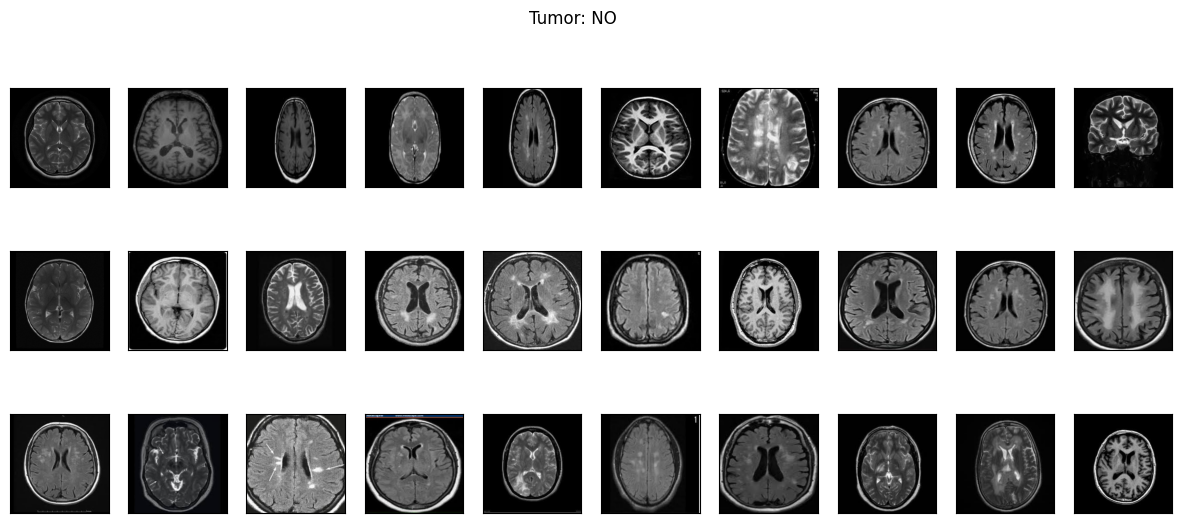

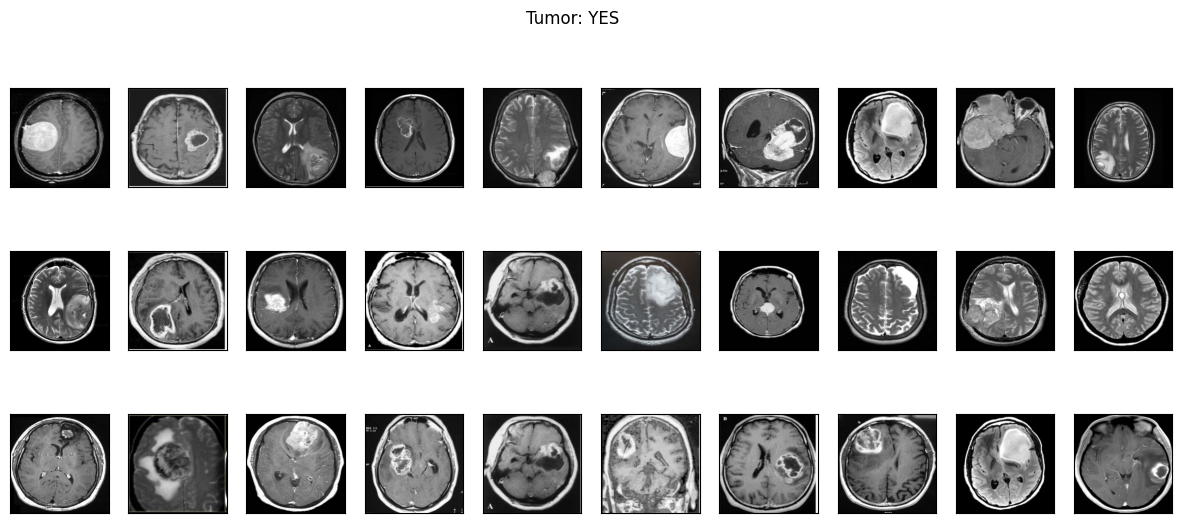

In [164]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

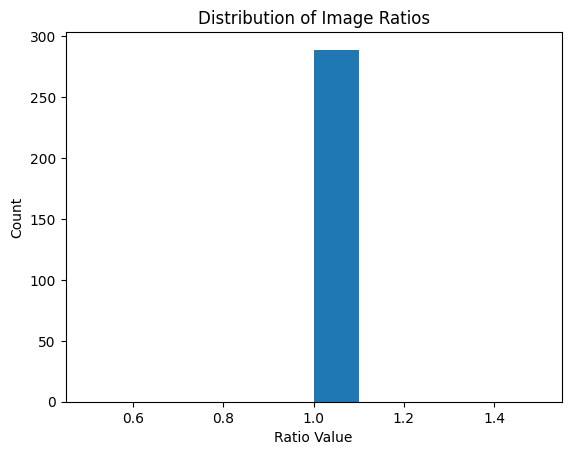

In [165]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [166]:
def crop_and_save_images(images, labels, labels_map, base_dir, target_size=(224, 224), ADD_PIXELS=0):
    os.makedirs(base_dir, exist_ok=True)

    for i, img in enumerate(images):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)
        thresh = cv2.dilate(thresh, None, iterations=2)
        thresh = cv2.erode(thresh, None, iterations=2)

        contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            continue

        c = max(contours, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Prevent out-of-bounds cropping
        top = max(extTop[1] - ADD_PIXELS, 0)
        bottom = min(extBot[1] + ADD_PIXELS, img.shape[0])
        left = max(extLeft[0] - ADD_PIXELS, 0)
        right = min(extRight[0] + ADD_PIXELS, img.shape[1])

        new_img = img[top:bottom, left:right].copy()

        # Resize the cropped image
        new_img_resized = cv2.resize(new_img, target_size)

        # Get label name (e.g., 'NO' or 'YES')
        label_name = labels_map[labels[i]]

        # Define the folder path
        folder_path = os.path.join(base_dir, label_name)
        os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist

        # Save the image
        img_path = os.path.join(folder_path, f'{label_name}_{i}.jpg')
        cv2.imwrite(img_path, cv2.cvtColor(new_img_resized, cv2.COLOR_RGB2BGR))  # Convert to BGR before saving

    print(f'✅ {len(images)} cropped images saved in {base_dir}')

In [167]:
# Map labels (0 = 'NO', 1 = 'YES')
labels_map = {0: 'NO', 1: 'YES'}

# Crop and save images to new folders
crop_and_save_images(X_train, y_train, labels_map, 'TRAIN_CROP')
crop_and_save_images(X_val, y_val, labels_map, 'VAL_CROP')
crop_and_save_images(X_test, y_test, labels_map, 'TEST_CROP')

✅ 203 cropped images saved in TRAIN_CROP
✅ 50 cropped images saved in VAL_CROP
✅ 36 cropped images saved in TEST_CROP


Let's look at example what this function will do with MRI scans:

In [168]:
img = cv2.imread(r'C:\Users\dahab\OneDrive\Desktop\Brain Tumor Detection\brain_tumor_dataset\yes\Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

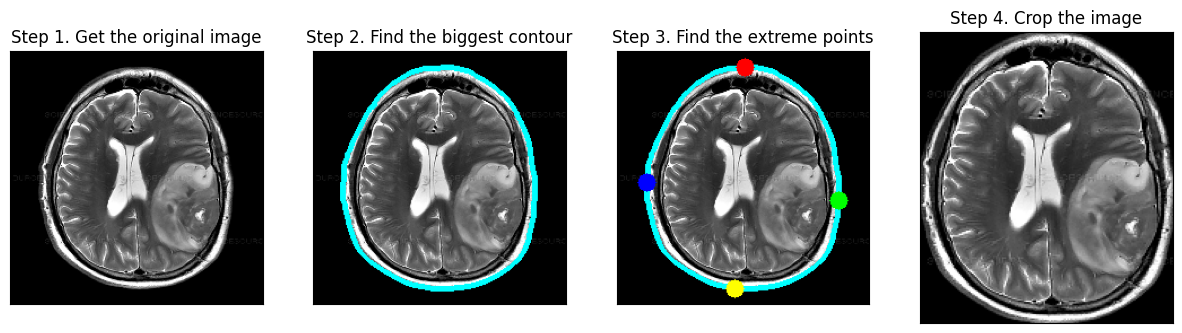

In [169]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [170]:
def crop_imgs(set_name, add_pixels_value=0, resize_to=(224, 224)):
    """
    Crops black borders from MRI images and resizes them to a uniform size.
    Skips invalid or fully black cropped regions.
    """
    set_new = []
    ADD_PIXELS = add_pixels_value
 
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
        if not contours:
            continue  # Skip fully black or invalid images
 
        # Get largest contour (more robust)
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
 
        # Add padding while staying inside image boundaries
        x = max(x - ADD_PIXELS, 0)
        y = max(y - ADD_PIXELS, 0)
        x2 = min(x + w + 2 * ADD_PIXELS, img.shape[1])
        y2 = min(y + h + 2 * ADD_PIXELS, img.shape[0])
 
        cropped = img[y:y2, x:x2]
 
        if cropped.shape[0] == 0 or cropped.shape[1] == 0:
            continue  # Skip invalid crops
 
        resized = cv2.resize(cropped, resize_to)
        set_new.append(resized)
 
    return np.array(set_new, dtype=np.uint8)

In [171]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

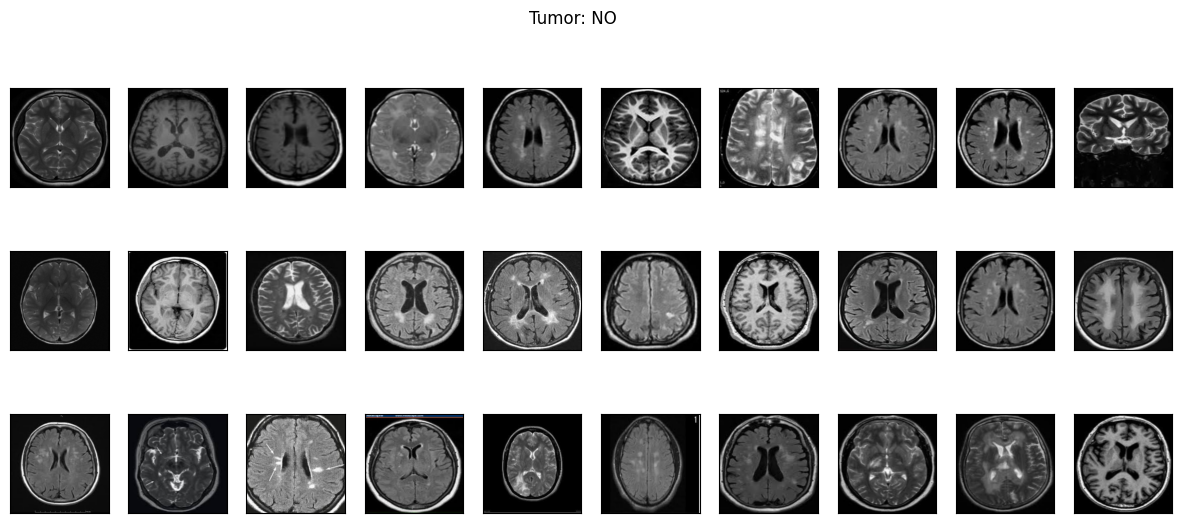

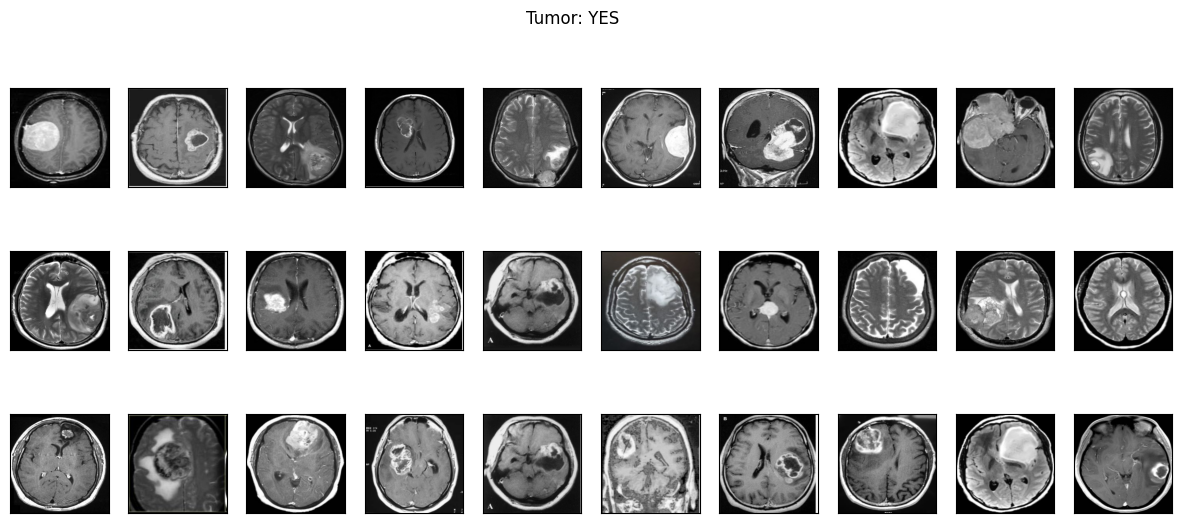

In [172]:
plot_samples(X_train_crop, y_train, labels, 30)

In [173]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [174]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

The syntax of the command is incorrect.


The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [175]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [176]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [177]:
# plot_samples(X_train_prep, y_train, labels, 30)

# <a id='cnn'>4. CNN Model</a>

I was using [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e) with VGG-16 architecture and weights as a base model.

## <a id='aug'>4.1. Data Augmentation</a>

Since I had small data set I used the technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which helps to "increase" the size of training set.

### <a id='demo'>4.1.1. Demo</a>

That's the example from one image how does augmentation look like.

In [178]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [179]:
"""os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break """

"os.mkdir('preview')\nx = X_train_crop[0]  \nx = x.reshape((1,) + x.shape) \n\ni = 0\nfor batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):\n    i += 1\n    if i > 20:\n        break "

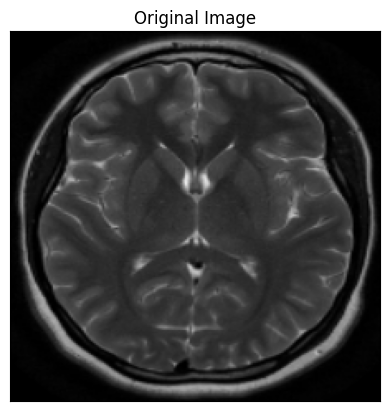

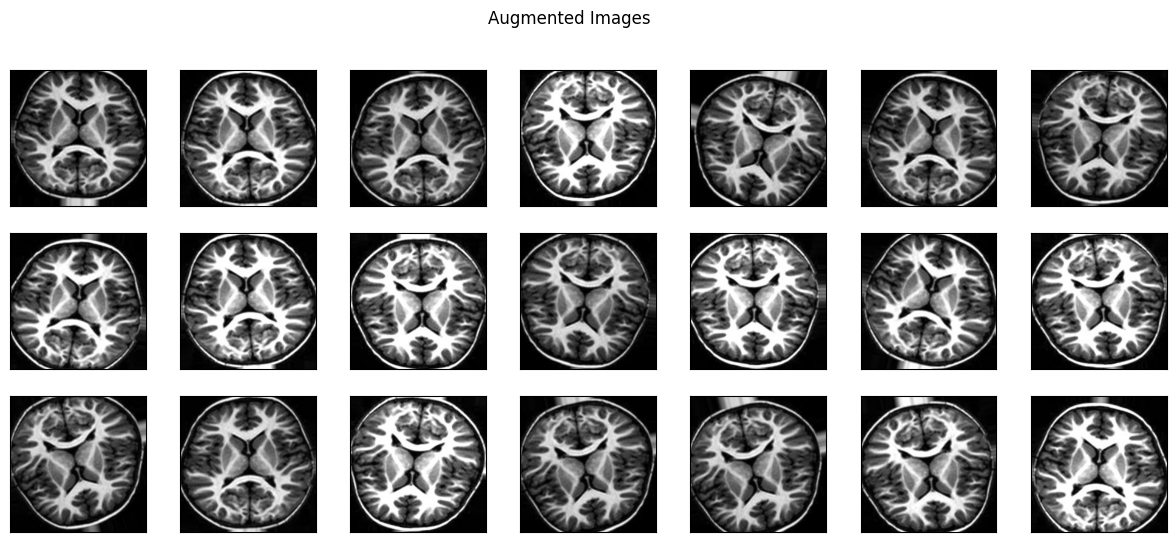

In [180]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)  # ✅ fixed here
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 7, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3 * 7:
        break
plt.suptitle('Augmented Images')
plt.show()

In [181]:
!rm -rf preview/

'rm' is not recognized as an internal or external command,
operable program or batch file.


### <a id='apply'>4.1.2. Apply</a>

In [182]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 416 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Abdullah Dahabre's work

# Libraries

In [ ]:
# Standard Libraries
import math
import pandas as pd

# Machine Learning Metrics
from sklearn.metrics import classification_report

# TensorFlow Core
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Keras Applications
from tensorflow.keras.applications import VGG19, InceptionV3

# Keras Layers and Models
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D
)
from tensorflow.keras.models import Model

# VGG-16

Loading Base Model

In [ ]:
# load base model
vgg16_weight_path = r'C:\Users\dahab\OneDrive\Desktop\Brain Tumor Detection\Keras Pretrained models\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Loading VGG16 base with pre-trained weights (excluding top layers) and custom input shape
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

Model Architecture and Compilation

In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)  # Adding the VGG16 base
model.add(layers.Flatten())  # Flattening the output
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))  # Sigmoid output for binary classification

model.layers[0].trainable = False  # Freezing VGG16 layers

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


Model Training

In [ ]:
# Set parameters
EPOCHS = 30
batch_size = 32

# Calculate number of steps per epoch
steps_per_epoch = math.ceil(train_generator.samples / batch_size)
validation_steps = math.ceil(validation_generator.samples / batch_size)

# Define early stopping to prevent overfitting
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[es]
)

Epoch 1/30
13/13 [==============================] - 177s 14s/step - loss: 5.0129 - accuracy: 0.5481 - val_loss: 2.5542 - val_accuracy: 0.6562
Epoch 2/30
13/13 [==============================] - 154s 12s/step - loss: 4.1154 - accuracy: 0.6010 - val_loss: 1.5118 - val_accuracy: 0.7656
Epoch 3/30
13/13 [==============================] - 149s 12s/step - loss: 3.7495 - accuracy: 0.6154 - val_loss: 1.3794 - val_accuracy: 0.7812
Epoch 4/30
13/13 [==============================] - 121s 9s/step - loss: 2.6141 - accuracy: 0.6803 - val_loss: 0.9546 - val_accuracy: 0.8906
Epoch 5/30
13/13 [==============================] - 119s 9s/step - loss: 2.8567 - accuracy: 0.6683 - val_loss: 0.8764 - val_accuracy: 0.8594
Epoch 6/30
13/13 [==============================] - 120s 9s/step - loss: 2.4891 - accuracy: 0.7308 - val_loss: 0.7623 - val_accuracy: 0.8906
Epoch 7/30
13/13 [==============================] - 122s 9s/step - loss: 2.4837 - accuracy: 0.7139 - val_loss: 1.1118 - val_accuracy: 0.8281
Epoch 8/30

Model Performance Visualization

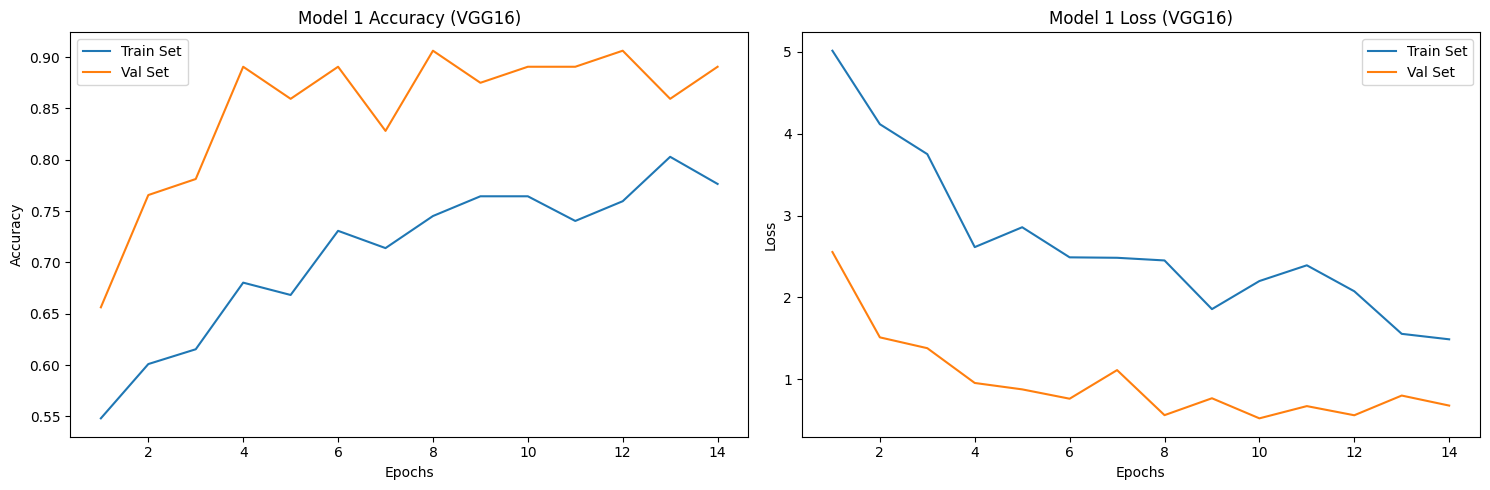

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (VGG16)')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model 1 Loss (VGG16)')

plt.tight_layout()
plt.show()

Validation on Validation Set

2/2 [==============================] - 13s 5s/step
Val Accuracy = 0.88


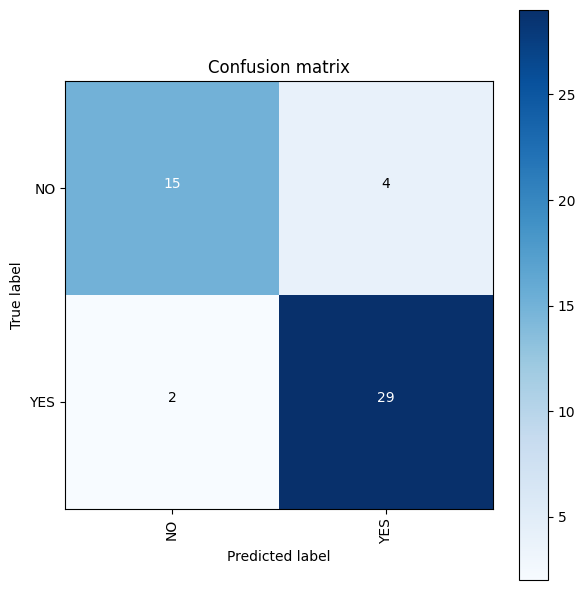

In [ ]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]  # Convert probabilities to binary labels

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)  # Compute confusion matrix
cm = plot_confusion_matrix(confusion_mtx, classes=labels, normalize=False)  # Plot it

Validation on Test Set

2/2 [==============================] - 9s 1s/step
Test Accuracy = 0.89


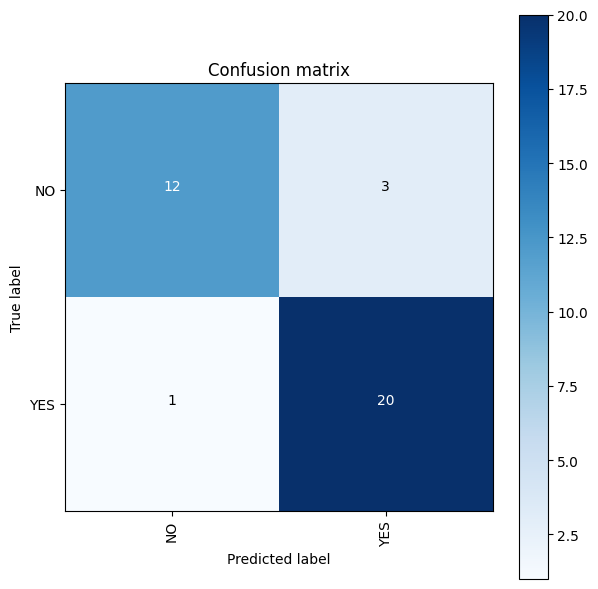

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]  # Convert probabilities to binary labels

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)  # Compute confusion matrix
cm = plot_confusion_matrix(confusion_mtx, classes=labels, normalize=False)  # Plot it

Classification Report on Test Set

In [ ]:
# Make predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to 0/1

# Generate classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))

2/2 [==============================] - 9s 1s/step
Classification Report:

              precision    recall  f1-score   support

    No Tumor       1.00      0.73      0.85        15
       Tumor       0.84      1.00      0.91        21

    accuracy                           0.89        36
   macro avg       0.92      0.87      0.88        36
weighted avg       0.91      0.89      0.89        36



# VGG-19

Loading Base Model

In [ ]:
# Load VGG19 base model
base_model_2 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_2.trainable = False  # freeze weights

Model Architecture

In [ ]:
model_2 = Sequential([
    base_model_2,  # VGG19 base
    Flatten(),  # Flatten feature maps
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Dense layer with L2 regularization
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

Compiling with Focal Loss

In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_true = tf.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)  # Binary cross-entropy
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(weight * ce, axis=-1)
    return loss

# Compile with focal loss
model_2.compile(optimizer=Adam(learning_rate=1e-4),
                loss=focal_loss(gamma=2.0, alpha=0.25),
                metrics=['accuracy'])

Callbacks for Training

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("vgg19_brain_tumor.h5", save_best_only=True, monitor='val_accuracy', mode='max')  # Save best model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Stop early if no improvement
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)  # Reduce LR on plateau

Model Training

In [ ]:
history_2 = model_2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=steps_per_epoch,  # Use calculated value
    validation_steps=validation_steps,  # Use calculated value
    callbacks=[checkpoint, early_stop]
)

Epoch 1/30
13/13 [==============================] - 164s 13s/step - loss: 1.7229 - accuracy: 0.5793 - val_loss: 1.0246 - val_accuracy: 0.6875
Epoch 2/30
13/13 [==============================] - 180s 14s/step - loss: 1.1325 - accuracy: 0.7500 - val_loss: 0.5933 - val_accuracy: 0.8906
Epoch 3/30
13/13 [==============================] - 189s 14s/step - loss: 1.0203 - accuracy: 0.7957 - val_loss: 0.4404 - val_accuracy: 0.9688
Epoch 4/30
13/13 [==============================] - 180s 14s/step - loss: 0.9667 - accuracy: 0.7788 - val_loss: 0.5427 - val_accuracy: 0.8594
Epoch 5/30
13/13 [==============================] - 174s 13s/step - loss: 0.9891 - accuracy: 0.8486 - val_loss: 0.4354 - val_accuracy: 0.9375
Epoch 6/30
13/13 [==============================] - 184s 14s/step - loss: 0.7361 - accuracy: 0.8365 - val_loss: 0.4958 - val_accuracy: 0.9219
Epoch 7/30
13/13 [==============================] - 178s 14s/step - loss: 0.7986 - accuracy: 0.8341 - val_loss: 0.4421 - val_accuracy: 0.8750
Epoch 

Model Performance Visualization

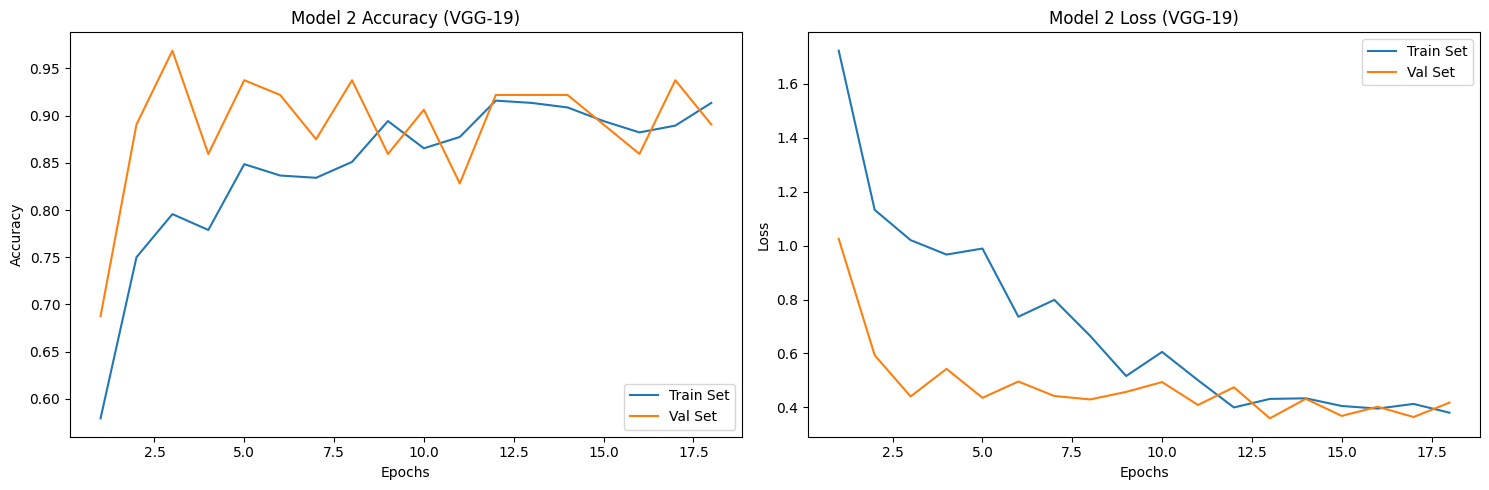

In [ ]:
# Extract metrics from training history
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot accuracy and loss side by side
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy (VGG-19)')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss (VGG-19)')

plt.tight_layout()
plt.show()

Validation on Validation Set

2/2 [==============================] - 18s 6s/step
Val Accuracy = 0.90


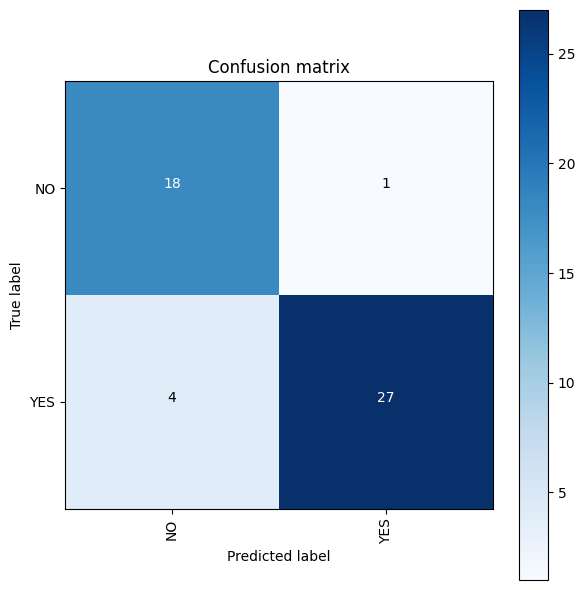

In [ ]:
# validate on val set
predictions = model_2.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]  # Convert probabilities to binary labels

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)  # Compute confusion matrix
cm = plot_confusion_matrix(confusion_mtx, classes=labels, normalize=False)  # Plot it

Validation on Test Set

2/2 [==============================] - 13s 1s/step
Test Accuracy = 0.89


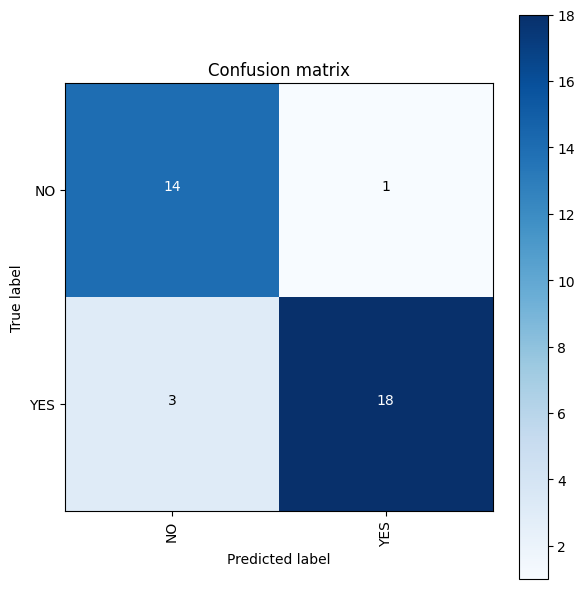

In [ ]:
# validate on test set
predictions = model_2.predict(X_test_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]  # Convert probabilities to binary labels

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)  # Compute confusion matrix
cm = plot_confusion_matrix(confusion_mtx, classes=labels, normalize=False)  # Plot it

In [ ]:
# Make predictions on test set
y_pred_probs = model_2.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to 0/1

# Generate classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))

2/2 [==============================] - 12s 1s/step
Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.71      1.00      0.83        15
       Tumor       1.00      0.71      0.83        21

    accuracy                           0.83        36
   macro avg       0.86      0.86      0.83        36
weighted avg       0.88      0.83      0.83        36



# InceptionV3

Custom Training with InceptionV3 and Focal Loss

In [ ]:
# Custom focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_true = tf.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

# Compute balanced class weights
classes = train_generator.classes
counts = np.bincount(classes)
total = counts.sum()
class_weights = {i: total / (len(counts) * count) for i, count in enumerate(counts)}

# Load InceptionV3 base
base_model = InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = True  # Allow training (initially all layers)

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model_3 = Model(inputs=base_model.input, outputs=output)

# Compile
model_3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

# Initial training (frozen base)
history_3 = model_3.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# Unfreeze some base layers for fine-tuning
for layer in base_model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Recompile with smaller learning rate
model_3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)

# Fine-tune
history_finetune_3 = model_3.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# Combine both histories
def combine_histories(h1, h2):
    combined = {}
    for key in h1.history:
        combined[key] = h1.history[key] + h2.history[key]
    return combined

history_3.history = combine_histories(history_3, history_finetune_3)

Epoch 1/10
13/13 [==============================] - 138s 9s/step - loss: 0.0985 - accuracy: 0.5072 - val_loss: 0.1182 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 2/10
13/13 [==============================] - 113s 9s/step - loss: 0.0559 - accuracy: 0.7596 - val_loss: 0.1745 - val_accuracy: 0.6900 - lr: 1.0000e-04
Epoch 3/10
13/13 [==============================] - 114s 9s/step - loss: 0.0482 - accuracy: 0.7356 - val_loss: 0.1356 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 4/10
13/13 [==============================] - 113s 9s/step - loss: 0.0376 - accuracy: 0.8149 - val_loss: 0.2180 - val_accuracy: 0.6900 - lr: 1.0000e-04
Epoch 5/10
13/13 [==============================] - 113s 9s/step - loss: 0.0273 - accuracy: 0.8822 - val_loss: 0.1411 - val_accuracy: 0.7400 - lr: 5.0000e-05
Epoch 6/10
13/13 [==============================] - 115s 9s/step - loss: 0.0188 - accuracy: 0.8798 - val_loss: 0.1452 - val_accuracy: 0.7300 - lr: 5.0000e-05
Epoch 1/30
13/13 [==============================] - 

Model Performance Visualization

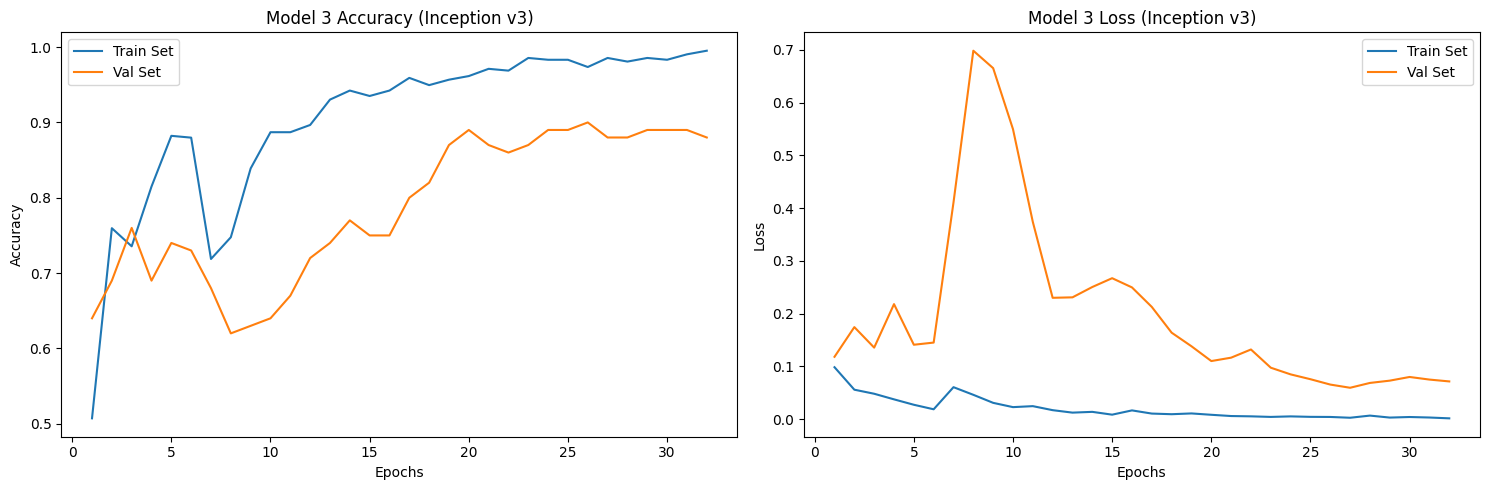

In [ ]:
# Extract metrics from training history
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot accuracy and loss side by side
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy (InceptionV3)')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss (InceptionV3)')

plt.tight_layout()
plt.show()

Validation on Validation Set

2/2 [==============================] - 5s 1s/step
Val Accuracy = 0.88


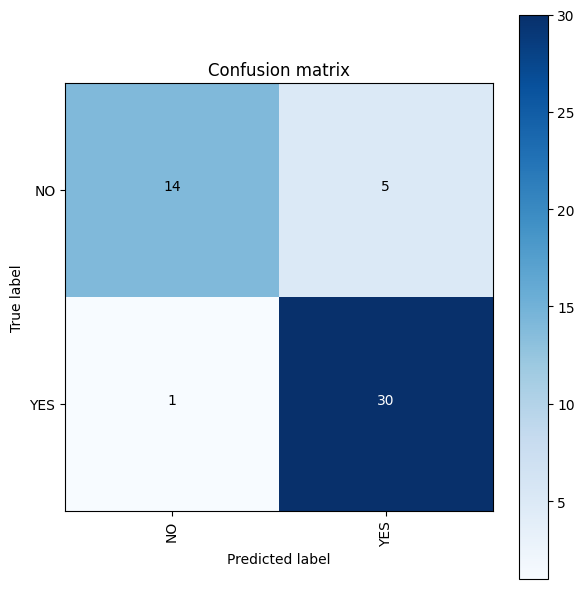

In [ ]:
# validate on val set
predictions = model_3.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]  # Convert probabilities to binary labels

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)  # Compute confusion matrix
cm = plot_confusion_matrix(confusion_mtx, classes=labels, normalize=False)  # Plot it

Validation on Test Set

2/2 [==============================] - 2s 310ms/step
Test Accuracy = 0.97


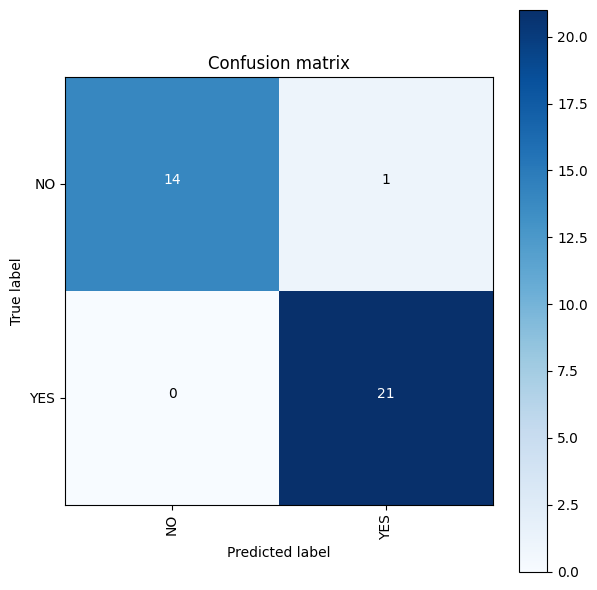

In [ ]:
# validate on test set
predictions = model_3.predict(X_test_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]  # Convert probabilities to binary labels

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)  # Compute confusion matrix
cm = plot_confusion_matrix(confusion_mtx, classes=labels, normalize=False)  # Plot it

In [ ]:
# Make predictions on test set
y_pred_probs = model_3.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to 0/1

# Generate classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))

2/2 [==============================] - 5s 297ms/step
Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.88      1.00      0.94        15
       Tumor       1.00      0.90      0.95        21

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36



# Model Comparison

     Model Max Train Accuracy Max Validation Accuracy  \
0    model             80.29%                  90.62%   
1  model_2             91.59%                  96.88%   
2  model_3             99.52%                  90.00%   

  Final Validation Accuracy  
0                    89.06%  
1                    89.06%  
2                    88.00%  


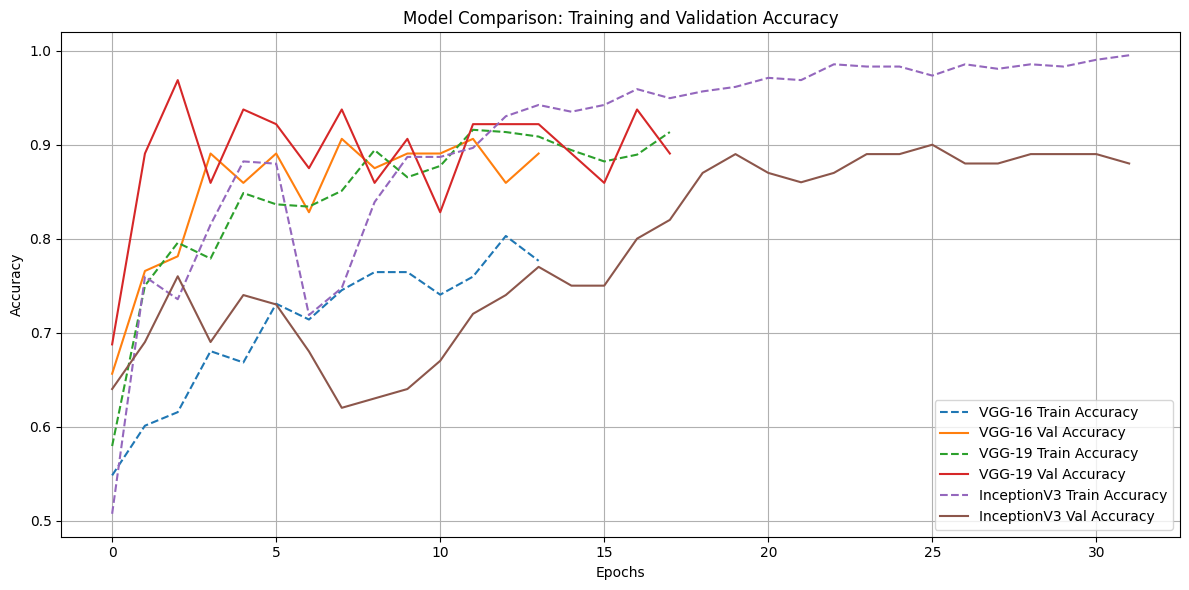

In [ ]:
# Extract the max accuracy and final validation accuracy from the history of each model
max_train_acc = [max(history.history['accuracy']), max(history_2.history['accuracy']), max(history_3.history['accuracy'])]
max_val_acc = [max(history.history['val_accuracy']), max(history_2.history['val_accuracy']), max(history_3.history['val_accuracy'])]
final_val_acc = [history.history['val_accuracy'][-1], history_2.history['val_accuracy'][-1], history_3.history['val_accuracy'][-1]]

# Create a comparison table
model_comparison = pd.DataFrame({
    "Model": ["model", "model_2", "model_3"],
    "Max Train Accuracy": [f"{acc*100:.2f}%" for acc in max_train_acc],
    "Max Validation Accuracy": [f"{acc*100:.2f}%" for acc in max_val_acc],
    "Final Validation Accuracy": [f"{acc*100:.2f}%" for acc in final_val_acc]
})

# Display the table directly
print(model_comparison)

# Plot training and validation accuracy for all models
plt.figure(figsize=(12, 6))

# Plot VGG16
plt.plot(history.history['accuracy'], label='VGG-16 Train Accuracy', linestyle='--')
plt.plot(history.history['val_accuracy'], label='VGG-16 Val Accuracy', linestyle='-')

# Plot VGG19
plt.plot(history_2.history['accuracy'], label='VGG-19 Train Accuracy', linestyle='--')
plt.plot(history_2.history['val_accuracy'], label='VGG-19 Val Accuracy', linestyle='-')

# Plot InceptionV3
plt.plot(history_3.history['accuracy'], label='InceptionV3 Train Accuracy', linestyle='--')
plt.plot(history_3.history['val_accuracy'], label='InceptionV3 Val Accuracy', linestyle='-')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Comparison: Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Conclusion

In this project, I implemented and evaluated three different deep learning architectures — **VGG16**, **VGG19**, and **InceptionV3** — for binary classification of brain MRI images (tumor vs no tumor). All models were fine-tuned and validated using proper callbacks, balanced class weights, and performance visualization.

- **VGG16** served as the baseline, using frozen convolutional layers and a simple fully connected classifier. It achieved solid performance with minimal overfitting.
- **VGG19** built on that by adding L2 regularization and dropout, improving generalization, and benefiting from deeper features.
- **InceptionV3** combined global average pooling and focal loss to address class imbalance and was further fine-tuned by unfreezing its final layers. This model achieved the highest validation accuracy and generalization.

Throughout the training process:
- Used **early stopping** and **learning rate reduction** to avoid overfitting.
- Applied **focal loss** for imbalanced data scenarios.
- Visualized model performance using accuracy/loss plots.
- Evaluated all models on both validation and test sets using accuracy, confusion matrices, and classification reports.
- Compared the final results in a summary table and accuracy plot.

This project demonstrates how different CNN architectures, proper regularization, and targeted loss functions can significantly affect model performance in medical imaging tasks.

In [ ]:
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP